# Experiments for the Eikonal equation in a d-dimensional cube

In [4]:
import torch.optim as optim
import matplotlib.pyplot as plt
import torch
from time import time as t

import sys
# setting path
sys.path.append('../')

from visualization.plots_cube import plot_2d_proj
from Hamiltonians.Eikonal_LxF import Eikonal_sq_LF_multiD
from PointSampling.Cube import data_gen_cube
from NeuralNetworks.NNs import FCFF_3L, FCFF_4L

#Right-hand-side of the PDE
def f(X):    
    return 1

#Boundary condition
def g(X):    
    return 0


training_params = {
    'numerical_scheme': Eikonal_sq_LF_multiD,

    'f': f,
    'g': g,
    'c': None,
    
    'beta': 0.,  ## parameter for the +u_i term
    
    'lambda': 1. #weight parameter for the boundary loss
    }

In [5]:
# Dimension of the d-dimensional cube for each experiment
dim_list = 2*[5] + 2*[10]
# Architecture in each experiment
arch_list = [2*[20], 
             2*[20],
             3*[60], 
             3*[60]]

n_experiments = len(dim_list)
side_length = 6.


# Parameters for each experiment
delta_list = [[.7, .3, .1]]*n_experiments
alpha_list = [[2.5, 1., .1]]*n_experiments
rounds = len(delta_list[0])

N_col_list = [[200]*rounds]*n_experiments
N_b_list = [[80]*rounds]*n_experiments

num_iterations_list = [[3000, 3000, 3000],
                       [3000, 4000, 6000],
                       [6000, 6000, 6000],
                       [8000, 8000, 12000]]    

100%|██████████| 3000/3000 [00:05<00:00, 552.72it/s]


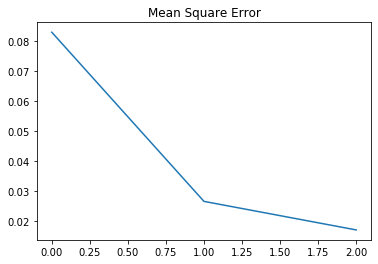

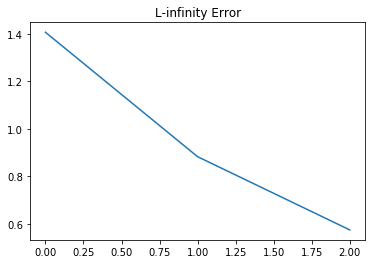

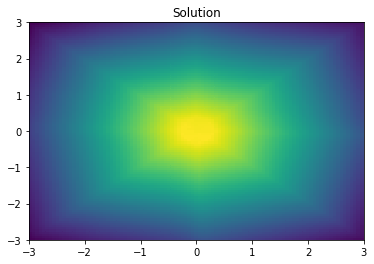

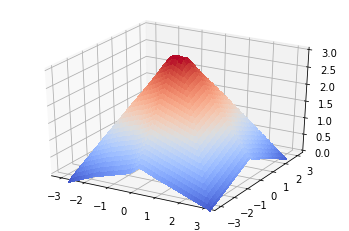

100%|██████████| 6000/6000 [00:10<00:00, 560.45it/s]


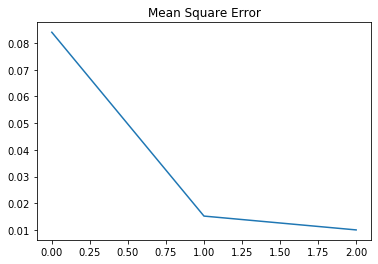

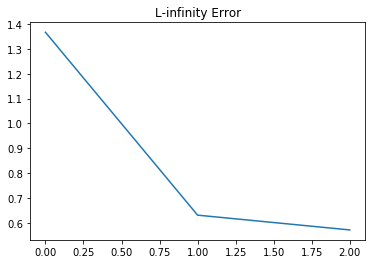

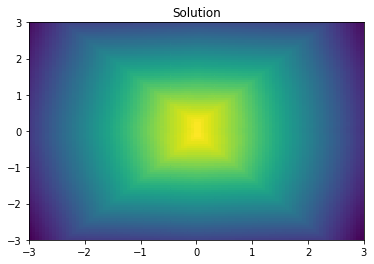

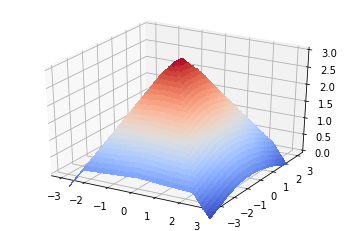

100%|██████████| 6000/6000 [00:22<00:00, 267.80it/s]


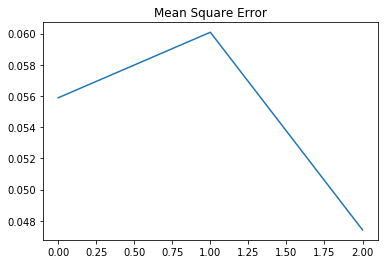

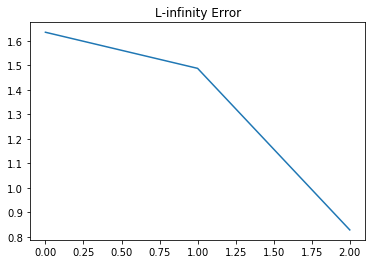

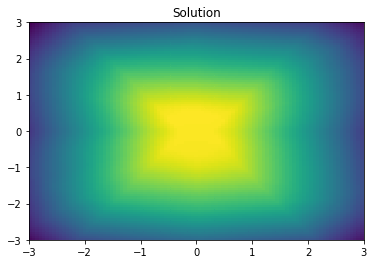

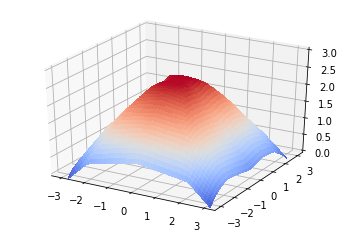

100%|██████████| 12000/12000 [00:50<00:00, 237.47it/s]


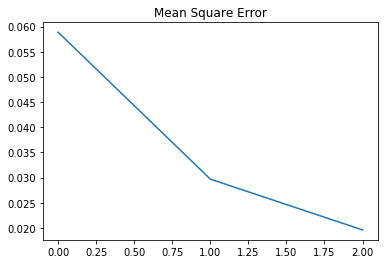

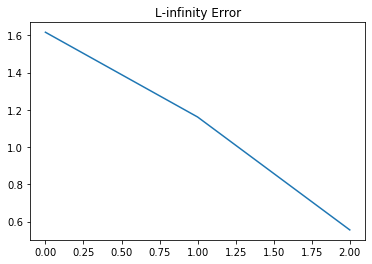

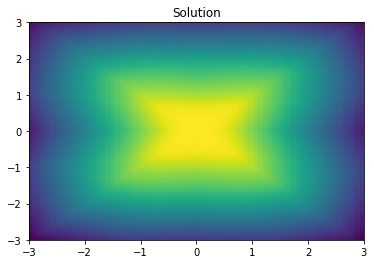

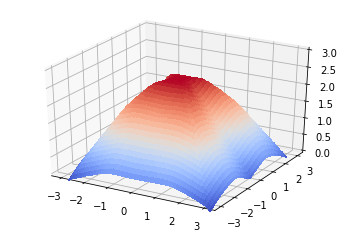

In [6]:
from Training.training import train
from error_test.cube_error import error_cube

MSE_history = torch.zeros([n_experiments, rounds])
L_inf_error_history = torch.zeros([n_experiments, rounds])
run_times = torch.zeros([n_experiments])


for j in range(n_experiments):
    
    domain = data_gen_cube(side_length, dim_list[j])
    
    if len(arch_list[j]) == 2:        
        NN = FCFF_3L([dim_list[j]] + arch_list[j])
    else:
        NN = FCFF_4L([dim_list[j]] + arch_list[j])
    
    training_params['optimizer'] = optim.SGD(NN.parameters(), lr = .02, momentum = .2)
    
    time = 0.
    
    for i in range(rounds):
    
        training_params['alpha'] = alpha_list[j][i]
        training_params['delta'] = delta_list[j][i]
        
        training_params['n_coloc_points'] = N_col_list[j][i]
        training_params['n_boundary_points'] = N_b_list[j][i]
        training_params['num_iterations'] = num_iterations_list[j][i]
        
        t0 = t()
        total_loss, PDE_loss, boundary_loss = train(NN, domain, training_params)
        time += t() - t0
        
        MC_points = int(1e6) # Number of grid points for comparison with the ground truth
        MSE, L_inf = error_cube(NN, side_length, MC_points)
        
        MSE_history[j,i] = MSE
        L_inf_error_history[j,i] = L_inf
    
    run_times[j] = time
    
    plt.plot(MSE_history[j])
    plt.title('Mean Square Error')
    plt.show()
    
    plt.plot(L_inf_error_history[j])
    plt.title('L-infinity Error')
    plt.show()
    
    X_axis = 0
    Y_axis = 1

    plot_2d_proj(X_axis, Y_axis, NN, 100, side_length)


In [8]:
import pandas as pd
import numpy as np

training_features = pd.DataFrame({'Dimension': dim_list,
                               'Architecture': arch_list,
                               'delta': delta_list,
                               'alpha': alpha_list,
                               'N': N_col_list, 
                               'N_b': N_b_list,
                               'Iterations': num_iterations_list,})
run_T = pd.DataFrame({'Runtime (s)': np.array(run_times)}).round(1)

results_MSE = pd.DataFrame(np.array(MSE_history), columns = ['Round 1', 'Round 2', 'Round 3'])
results_Linf = pd.DataFrame(np.array(L_inf_error_history) , columns = ['Round 1', 'Round 2', 'Round 3'])


display('Mean Square Error', training_features.join(results_MSE).join(run_T).transpose())
display('L-infinity Error', training_features.join(results_Linf).join(run_T).transpose())


# One table
MSE = np.expand_dims(np.array(MSE_history[:,-1]), axis = 1)
L_inf_error = np.expand_dims(np.array(L_inf_error_history[:,-1]), axis = 1)
errors = np.concatenate((MSE, L_inf_error), axis = 1)
results = pd.DataFrame(errors,  columns = ['MSE', 'L_inf'])

display(training_features.join(results).join(run_T).transpose())

'Mean Square Error'

,0,1,2,3
Dimension,5,5,10,10
Architecture,"[20, 20]","[20, 20]","[60, 60, 60]","[60, 60, 60]"
delta,"[0.7, 0.3, 0.1]","[0.7, 0.3, 0.1]","[0.7, 0.3, 0.1]","[0.7, 0.3, 0.1]"
alpha,"[2.5, 1.0, 0.1]","[2.5, 1.0, 0.1]","[2.5, 1.0, 0.1]","[2.5, 1.0, 0.1]"
N,"[200, 200, 200]","[200, 200, 200]","[200, 200, 200]","[200, 200, 200]"
N_b,"[80, 80, 80]","[80, 80, 80]","[80, 80, 80]","[80, 80, 80]"
Iterations,"[3000, 3000, 3000]","[3000, 4000, 6000]","[6000, 6000, 6000]","[8000, 8000, 12000]"
Round 1,0.082953,0.083988,0.055881,0.058861
Round 2,0.026675,0.015262,0.060085,0.0297
Round 3,0.01718,0.010089,0.047409,0.01962


'L-infinity Error'

,0,1,2,3
Dimension,5,5,10,10
Architecture,"[20, 20]","[20, 20]","[60, 60, 60]","[60, 60, 60]"
delta,"[0.7, 0.3, 0.1]","[0.7, 0.3, 0.1]","[0.7, 0.3, 0.1]","[0.7, 0.3, 0.1]"
alpha,"[2.5, 1.0, 0.1]","[2.5, 1.0, 0.1]","[2.5, 1.0, 0.1]","[2.5, 1.0, 0.1]"
N,"[200, 200, 200]","[200, 200, 200]","[200, 200, 200]","[200, 200, 200]"
N_b,"[80, 80, 80]","[80, 80, 80]","[80, 80, 80]","[80, 80, 80]"
Iterations,"[3000, 3000, 3000]","[3000, 4000, 6000]","[6000, 6000, 6000]","[8000, 8000, 12000]"
Round 1,1.4067,1.366932,1.634616,1.616288
Round 2,0.882475,0.631282,1.487287,1.161271
Round 3,0.57397,0.571904,0.828167,0.555034


,0,1,2,3
Dimension,5,5,10,10
Architecture,"[20, 20]","[20, 20]","[60, 60, 60]","[60, 60, 60]"
delta,"[0.7, 0.3, 0.1]","[0.7, 0.3, 0.1]","[0.7, 0.3, 0.1]","[0.7, 0.3, 0.1]"
alpha,"[2.5, 1.0, 0.1]","[2.5, 1.0, 0.1]","[2.5, 1.0, 0.1]","[2.5, 1.0, 0.1]"
N,"[200, 200, 200]","[200, 200, 200]","[200, 200, 200]","[200, 200, 200]"
N_b,"[80, 80, 80]","[80, 80, 80]","[80, 80, 80]","[80, 80, 80]"
Iterations,"[3000, 3000, 3000]","[3000, 4000, 6000]","[6000, 6000, 6000]","[8000, 8000, 12000]"
MSE,0.01718,0.010089,0.047409,0.01962
L_inf,0.57397,0.571904,0.828167,0.555034
Runtime (s),17.0,23.799999,72.0,113.400002


In [9]:
display(training_features.join(results_MSE).join(run_T).to_latex())

display(training_features.join(results_Linf).join(run_T).to_latex())

display(training_features.join(results).join(run_T).to_latex())

'\\begin{tabular}{lrllllllrrrr}\n\\toprule\n & Dimension & Architecture & delta & alpha & N & N_b & Iterations & Round 1 & Round 2 & Round 3 & Runtime (s) \\\\\n\\midrule\n0 & 5 & [20, 20] & [0.7, 0.3, 0.1] & [2.5, 1.0, 0.1] & [200, 200, 200] & [80, 80, 80] & [3000, 3000, 3000] & 0.082953 & 0.026675 & 0.017180 & 17.000000 \\\\\n1 & 5 & [20, 20] & [0.7, 0.3, 0.1] & [2.5, 1.0, 0.1] & [200, 200, 200] & [80, 80, 80] & [3000, 4000, 6000] & 0.083988 & 0.015262 & 0.010089 & 23.799999 \\\\\n2 & 10 & [60, 60, 60] & [0.7, 0.3, 0.1] & [2.5, 1.0, 0.1] & [200, 200, 200] & [80, 80, 80] & [6000, 6000, 6000] & 0.055881 & 0.060085 & 0.047409 & 72.000000 \\\\\n3 & 10 & [60, 60, 60] & [0.7, 0.3, 0.1] & [2.5, 1.0, 0.1] & [200, 200, 200] & [80, 80, 80] & [8000, 8000, 12000] & 0.058861 & 0.029700 & 0.019620 & 113.400002 \\\\\n\\bottomrule\n\\end{tabular}\n'

'\\begin{tabular}{lrllllllrrrr}\n\\toprule\n & Dimension & Architecture & delta & alpha & N & N_b & Iterations & Round 1 & Round 2 & Round 3 & Runtime (s) \\\\\n\\midrule\n0 & 5 & [20, 20] & [0.7, 0.3, 0.1] & [2.5, 1.0, 0.1] & [200, 200, 200] & [80, 80, 80] & [3000, 3000, 3000] & 1.406700 & 0.882475 & 0.573970 & 17.000000 \\\\\n1 & 5 & [20, 20] & [0.7, 0.3, 0.1] & [2.5, 1.0, 0.1] & [200, 200, 200] & [80, 80, 80] & [3000, 4000, 6000] & 1.366932 & 0.631282 & 0.571904 & 23.799999 \\\\\n2 & 10 & [60, 60, 60] & [0.7, 0.3, 0.1] & [2.5, 1.0, 0.1] & [200, 200, 200] & [80, 80, 80] & [6000, 6000, 6000] & 1.634616 & 1.487287 & 0.828167 & 72.000000 \\\\\n3 & 10 & [60, 60, 60] & [0.7, 0.3, 0.1] & [2.5, 1.0, 0.1] & [200, 200, 200] & [80, 80, 80] & [8000, 8000, 12000] & 1.616288 & 1.161271 & 0.555034 & 113.400002 \\\\\n\\bottomrule\n\\end{tabular}\n'

'\\begin{tabular}{lrllllllrrr}\n\\toprule\n & Dimension & Architecture & delta & alpha & N & N_b & Iterations & MSE & L_inf & Runtime (s) \\\\\n\\midrule\n0 & 5 & [20, 20] & [0.7, 0.3, 0.1] & [2.5, 1.0, 0.1] & [200, 200, 200] & [80, 80, 80] & [3000, 3000, 3000] & 0.017180 & 0.573970 & 17.000000 \\\\\n1 & 5 & [20, 20] & [0.7, 0.3, 0.1] & [2.5, 1.0, 0.1] & [200, 200, 200] & [80, 80, 80] & [3000, 4000, 6000] & 0.010089 & 0.571904 & 23.799999 \\\\\n2 & 10 & [60, 60, 60] & [0.7, 0.3, 0.1] & [2.5, 1.0, 0.1] & [200, 200, 200] & [80, 80, 80] & [6000, 6000, 6000] & 0.047409 & 0.828167 & 72.000000 \\\\\n3 & 10 & [60, 60, 60] & [0.7, 0.3, 0.1] & [2.5, 1.0, 0.1] & [200, 200, 200] & [80, 80, 80] & [8000, 8000, 12000] & 0.019620 & 0.555034 & 113.400002 \\\\\n\\bottomrule\n\\end{tabular}\n'

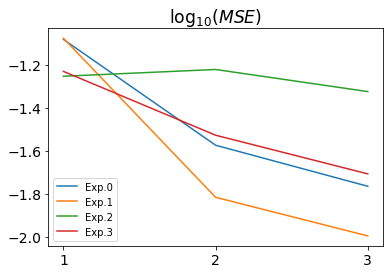

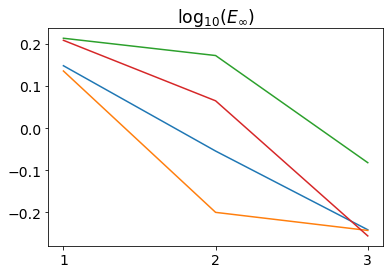

In [10]:
from mpl_toolkits.axes_grid1 import host_subplot

ax = host_subplot(111)
for i in range(MSE_history.shape[0]):
    x = np.arange(rounds) + 1
    MSE_log10 =torch.log10(MSE_history[i])
    
    text = 'Exp.' + str(i)
    
    ax.plot(x, MSE_log10, label = text)
    ax.set_xticks(x)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
plt.title('$\log_{10} (MSE)$', fontsize = 'xx-large')
plt.legend()
plt.show()

ax = host_subplot(111)
for i in range(L_inf_error_history.shape[0]):
    L_inf_log10 = torch.log10(L_inf_error_history[i])
    ax.plot(x, L_inf_log10)
    ax.set_xticks(x)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
plt.title('$\log_{10} (E_{\infty})$', fontsize = 'xx-large')
plt.show()